In [1]:
# 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier # StackingClassifier는 sklearn.ensemble에 있음
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

In [3]:
# 데이터 불러오기
X, y = make_moons(n_samples=1000, noise=0.3)

# make_moons 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [5]:
# 시각화를 위한 헬퍼 함수 (이전 실습에서 사용한 것과 동일)
def plot_decision_boundary(clf, X, y, ax, title): # ax 축
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])


    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    ax.scatter(X[:, 0][y==0], X[:, 1][y==0], c='red', marker='o', label='Class 0')
    ax.scatter(X[:, 0][y==1], X[:, 1][y==1], c='blue', marker='x', label='Class 1')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.grid(True)

소프트 보팅 분류기 정확도:  0.9066666666666666
배깅 분류기 정확도:  0.9033333333333333
그래디언트 부스팅 정확도:  0.91
스태킹 분류기 정확도:  0.91


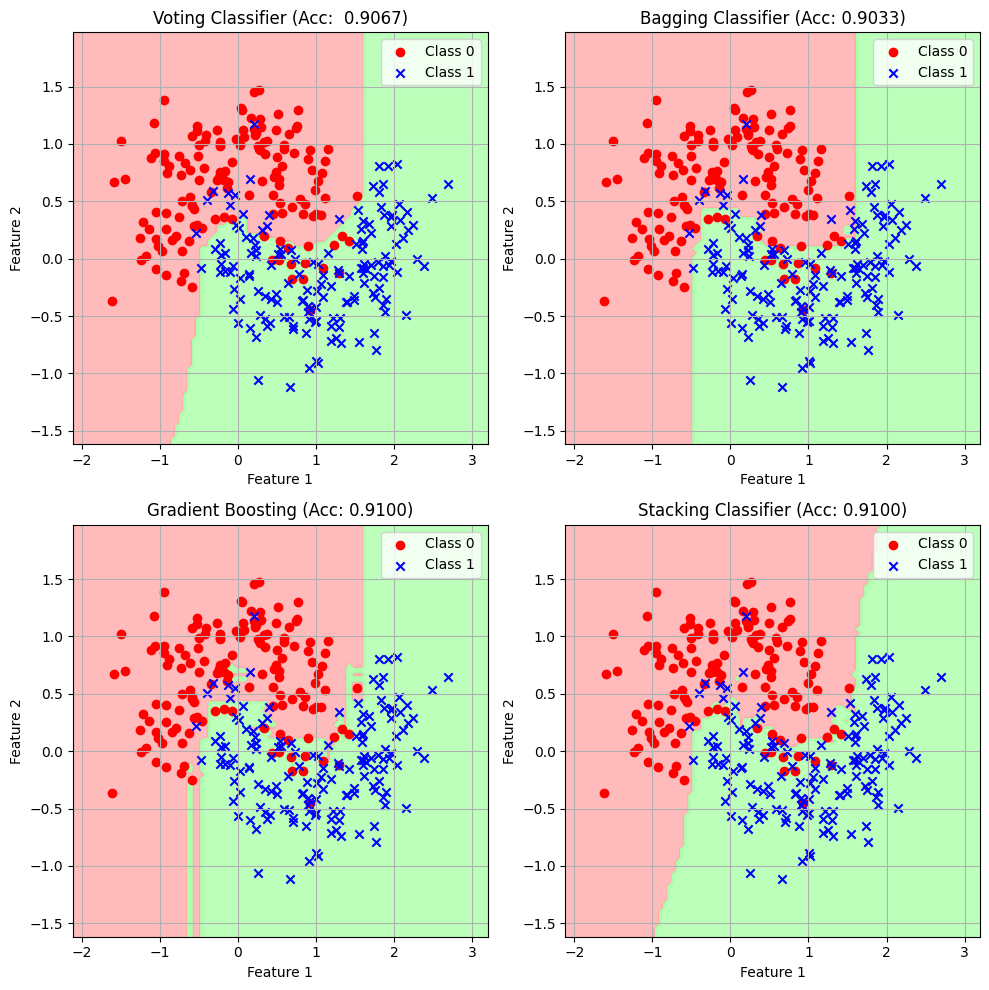


--- 최종 앙상블 모델별 정확도 비교 ---
소프트 보팅: 0.9067
배깅: 0.9033
Gradient Boosting: 0.9100
Stacking: 0.9100


In [12]:
# 모델별 정확도 저장 딕셔너리
accuracies = {

}

# 전체 시각화 준비
fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 10)
)
axes = axes.flatten() # 차원이 높은 배열을 차수를 줄여서 결국 평면 시각화를 가능하게 해줌

# --- 1. 보팅 (Voting) ---
# 1-1. 여러 개의 다른 알고리즘을 생성
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier(max_depth=5)
clf3 = SVC(probability=True)

# 1-2. 소프트 보팅: 확률을 가지고 최종 결정
voting_clf = VotingClassifier(
    estimators=[('lr', clf1), ('dt', clf2), ('svc', clf3)],
    voting='soft',
    weights=[1, 1, 1],
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
accuracies['소프트 보팅'] = accuracy_voting

plot_decision_boundary(voting_clf, X_test, y_test, axes[0], f'Voting Classifier (Acc: {accuracy_voting: .4f})')
print("소프트 보팅 분류기 정확도: ", accuracy_voting)

# --- 2. 배깅 (Bagging) ---
# BaggingClassifier는 DecisionTreeClassifier를 기본 베이스 모델로 사용합니다.
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),
    random_state=42,
    n_estimators=100,
    max_samples=0.8, # 각 트리가 훈련 데이터의 80%를 쓰겠다
    bootstrap=True,
    n_jobs=-1
)

bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)
accuracy_bagging  = accuracy_score(y_test, y_pred_bagging)
accuracies['배깅'] = accuracy_bagging
plot_decision_boundary(bagging_clf, X_test, y_test, axes[1], f'Bagging Classifier (Acc: {accuracy_bagging:.4f})')
print("배깅 분류기 정확도: ", accuracy_bagging)

# --- 3.부스팅 (Gradient Boosting) ---
# AdaBoost 대신 GradientBoostingClassifier 사용
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
accuracies['Gradient Boosting'] = accuracy_gb
plot_decision_boundary(gb_clf, X_test, y_test, axes[2], f'Gradient Boosting (Acc: {accuracy_gb:.4f})')
print("그래디언트 부스팅 정확도: ", accuracy_gb)

# --- 4.스태킹 (Stacking) ---
# 4-1. 베이스 모델들
estimators = [
    ('lr', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# 4-2 메타 모델 (최종 예측 모델)
# cv: 교차 검증 폴드 수 (메타 모델 학습 시 과적합 방지)
# stack_method: 베이스 모델의 예측을 어떻게 메타 모델에 전달할지 (predict_proba 또는 predict)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=5, # 교차검증
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
accuracies['Stacking'] = accuracy_stacking

plot_decision_boundary(stacking_clf, X_test, y_test, axes[3], f'Stacking Classifier (Acc: {accuracy_stacking:.4f})')
print("스태킹 분류기 정확도: ", accuracy_stacking)

plt.tight_layout()
plt.show()

# --- 최종 정확도 비교 ---
print("\n--- 최종 앙상블 모델별 정확도 비교 ---")
for model_name, acc in accuracies.items():
    print(f"{model_name}: {acc:.4f}")